# End the Bracket War
*or at least an attempt to*

A few days ago we started an `R` project at work. We want the code to be as consistent as possible but don't really have a coding style guide in place to follow so we decided to just make one. One of the things we need to settle on is where to place the opening bracket of a code block (It's the most important thing in the world I know), on which we disagree with one other. Basically there are 2 dominant styles:

    function(...) {
        ...
        return()
    }

    if ... {
        ...
    } else {
        ...
    }
    
    while ... {
        ...
    }

which I call the same-line style, and

    function(...)
    {
        ...
        return()
    }
    
    if ...
    {
        ...
    } 
    else
    {
        ...
    }
    
    while ...
    {
        ...
    }

which I call the new-line style. Personally I prefer the same-line style. I can't justify a single bracket occupying a whole line. And since you have code indentation you don't really need opening bracket on a new line to see where your code block begins. And of course the most important reason: same-lines just look much prettier, but that's just my opinion and I know quite a few people who disagree with me.

I was curious to see which style is more popular. Having too much time on my hands I conducted a survey around the office, but the sample size is too small so it doesn't really mean anything.

Thus I decided to just ask every one in the `R` developer community (or at least the most important people) instead. The idea is simple: crawl code from the most popular `R` packages and see which style is used most often.

Below is the code + explanation. If you are impatient or just want to see the result here's a [TL;DR](#And-the-results). If you are even more impatient here's a [TL;DR(TL;DR)](#Conclusion). If you are interested in trying this yourself here's the [link](https://github.com/kiendang/bracket-style-war) to the Jupyter notebook.

## Dependencies

First we load the few packages we need for this project. Apart from those listed below we also need `stringr`, `readr` and `data.table`, but I prefer not to attach them here and instead access the methods I want using `::`.

In [1]:
library(DBI)
library(dplyr)
library(ggplot2)
library(git2r)
library(MonetDBLite)
library(tidyr)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘git2r’

The following object is masked from ‘package:DBI’:

    fetch



In [2]:
options(repr.plot.width = 4, repr.plot.height = 4)

## Getting the 100 most downloaded packages

[cran-logs](http://cran-logs.rstudio.com/) provides package download statistics of [RStudio CRAN mirror](http://cran.rstudio.com/) in csv format. Each file contains download data in one day from 01/10/2012 to present. A row in a file corresponds to 1 download, which tell us which package was downloaded, at what time and from where, as well as other information.

We can get the names of the 100 most downloaded packages by downloading all these files, merging them in some way, counting the total number of downloads by packages and choose the 100 packages with the most download counts.

Create a directory to download CRAN statistics csv files:

In [3]:
data_dir <- "data"
if (!dir.exists(data_dir)) {
    dir.create(data_dir)
}

Get all the dates from 01/10/2012 to yesterday:

In [4]:
start <- as.Date("2012-10-01")
end <- Sys.Date() - 1
cran_stats <- data.frame(date = seq(start, end, "day"))

Getting the url for each file as well as the location to which it will be downloaded:

In [5]:
cran_stats <-
    cran_stats %>%
    mutate(year = as.POSIXlt(date)$year + 1900,
           url = sprintf("http://cran-logs.rstudio.com/%d/%s.csv.gz", year, date),
           path = file.path(data_dir, basename(url)))
head(cran_stats)

date,year,url,path
2012-10-01,2012,http://cran-logs.rstudio.com/2012/2012-10-01.csv.gz,data/2012-10-01.csv.gz
2012-10-02,2012,http://cran-logs.rstudio.com/2012/2012-10-02.csv.gz,data/2012-10-02.csv.gz
2012-10-03,2012,http://cran-logs.rstudio.com/2012/2012-10-03.csv.gz,data/2012-10-03.csv.gz
2012-10-04,2012,http://cran-logs.rstudio.com/2012/2012-10-04.csv.gz,data/2012-10-04.csv.gz
2012-10-05,2012,http://cran-logs.rstudio.com/2012/2012-10-05.csv.gz,data/2012-10-05.csv.gz
2012-10-06,2012,http://cran-logs.rstudio.com/2012/2012-10-06.csv.gz,data/2012-10-06.csv.gz


Choose only the files which have not been downloaded before. Files are csv's compressed into gz's which add up to 9.6G.

In [6]:
files_to_dl <-
    cran_stats %>%
    filter(!file.exists(path))

Download the files:

In [7]:
if (nrow(files_to_dl) > 0) {
    mapply(function(url, path) {
        tryCatch(download.file(url, path), error = function(e) {
            print(e)
        })
    }, files_to_dl$url, files_to_dl$path)
}

Get all the files available, including those downloaded before as well as just downloaded:

In [8]:
cran_stats <-
    cran_stats %>%
    filter(file.exists(path))

Since the total decompressed size of all these files is around 20G which is a bit much for my laptop memory, I'm going to create a database and read them all into a table. The database I'm using is `MonetDB`. Thanks to the `MonetDBLite` package I don't need to go through the hustle of manually setting up a database outside of `R`.

In [9]:
db_dir <- "db"
conn <- dbConnect(MonetDBLite(), db_dir)

Create a table to store all the file in `MonetDB` by read in the first file. Here I'm not running this command as well as the next one since I've already read all the files into the database before. However if you want to try this yourself you should run those 2 (one time only).

In [ ]:
monetdb.read.csv(conn, cran_stats$path[1], "dl_stats", create = TRUE)

Sequentially read all the files into the table. Alternatively you can first merge all of them into a single file and read it in.

In [ ]:
for (path in cran_stats$path[-1]) {
    tryCatch({
        monetdb.read.csv(conn, path, "dl_stats", create = FALSE)
    }, error = function(e) {
        print(e)
    })
}

Getting the schema of the table we just created:

In [10]:
schema <- dbGetQuery(conn, "SELECT c.name as column, c.type, c.type_digits
                            FROM sys.columns c INNER JOIN sys.tables t
                            ON c.table_id = t.id AND t.name = 'dl_stats'")
schema

column,type,type_digits
date,clob,0
time,clob,0
size,int,32
r_version,clob,0
r_arch,clob,0
r_os,clob,0
package,clob,0
version,clob,0
country,clob,0
ip_id,int,32


Get the 100 most downloaded packages:

In [11]:
top_pkgs <- dbGetQuery(conn, "SELECT * FROM
                              (SELECT package, count(*) AS download_count
                              FROM dl_stats GROUP BY package) AS srsly
                              ORDER BY download_count DESC LIMIT 100")
head(top_pkgs, 10)

package,download_count
Rcpp,7147778
ggplot2,6623242
stringr,5676205
plyr,5641686
digest,5609258
reshape2,4876988
scales,4829021
colorspace,4654707
RColorBrewer,4555700
stringi,4454863


That's all we need from `MonetDB` so I'm going to disconnect from it.

In [12]:
dbDisconnect(conn)

[1] TRUE

## Counting number of matches in each style in each package

Here we're going to count the number of strings that match either the same line style or the new line style for each package.

The way we're doing it is download all the *.R* files in each package. Those reside in the *R* directory on the package. Then we go through each file, count the total number of same-lines and new-lines. We do that for all the 100 packages.

Define the regular expression to match either group 1, the same-line style, or group 2, the new-line style:

In [13]:
# I know it's probably possible to shorten this regex but this does the job.
before_parents <- "(?:(?:function\\h*\\(.*\\)|(?:(?:if|while)\\h+\\S[^\\v]+)|(?:if|while)\\(.*\\))|else)"
patterns <- sprintf("(%s%s)|(%s%s)",
                    before_parents, "\\h*\\{\\h*\\v",
                    before_parents, "\\h*\\v\\s*\\{\\h*\\v")
cat(patterns)

((?:(?:function\h*\(.*\)|(?:(?:if|while)\h+\S[^\v]+)|(?:if|while)\(.*\))|else)\h*\{\h*\v)|((?:(?:function\h*\(.*\)|(?:(?:if|while)\h+\S[^\v]+)|(?:if|while)\(.*\))|else)\h*\v\s*\{\h*\v)

Create a directory where we clone the package:

In [14]:
repos_dir <- "repos"
if (!dir.exists(repos_dir)) {
    dir.create(repose_dir)
}

Create a csv file where we store the result. The header is *package* (name of package), *same_line* (number of strings that match the same line styles), *new_line* (number of strings that match the new line style), *result* (*same_line* if there are more same-lines than new-lines, *new_line* if there are more new_lines and *tie* if there's a tie).

In [15]:
results <- data.frame(package = character(),
                      same_line = integer(),
                      new_line = integer(),
                      result = character(), stringsAsFactors = FALSE)
results

package,same_line,new_line,result


Again I'm not going to run this code block as well as the next since I've done this before, but you should if you want to try this yourself. It doesn't take that long though. It's only a few minutes for me and 5 of those are due to the 3 seconds of waiting I put after I'm done with each package.

In [16]:
result_file <- "result.csv"

In [ ]:
write.table(results, file = result_file, sep = ",",
            row.names = FALSE, col.names = TRUE, quote = FALSE)

We go through each package, clone the *R* directory from [an unofficial read-only mirror of all CRAN R packages](https://github.com/cran). The reason why I don't use an official CRAN mirror is because there each package is compressed into a single *.tar.gz* file while I want the *R* directory only.

After getting the code files we go through each of them, count the total number of matches in each style, append the result to the csv file we created earlier, delete the code, and wait a few before we start again with another package.

In [ ]:
for (pkg in top_pkgs$package) {
    
    ##################################################################
    # Clone package
    ##################################################################
    
    repo_dir <- file.path(repos_dir, pkg)
    if (!dir.exists(repo_dir)) {
        dir.create(repo_dir)
    }
    
    # Use sparse-checkout to download only R files in the R directory
    repo <- init(repo_dir)
    config(repo, core.sparsecheckout = "true")
    remote_add(repo, "origin", sprintf("https://github.com/cran/%s.git", pkg))
    cat("R/*.R", file = file.path(repo_dir, ".git", "info", "sparse-checkout"))
    
    # Cannot use git2r to do this, or at least I don't know how
    curr_dir <- setwd(repo_dir)
    system("git pull --depth=1 origin master")
    setwd(curr_dir)
    
    ##################################################################
    # Count number of occurences of each style (same line or new line)
    ##################################################################
    
    files <- list.files(file.path(repo_dir, "R"))
    if (length(files) <= 0) {
        unlink(repo_dir, recursive = TRUE)
        Sys.sleep(3)
        next
    }
    
    # Read contents of R files as strings
    file_strs <- sapply(files, function(file_name) {
        file_str <- readr::read_file(file.path(repo_dir, "R", file_name))
    })
    
    # Use str_match_all from stringr to get strings that match either style
    # as well as which style they match
    matches <- stringr::str_match_all(file_strs, patterns)
    
    # Count number of matches in each style in each file
    style_counts <- lapply(matches, function(m) {
        list(same_line = sum(m[, 2] != ""), new_line = sum(m[, 3] != ""))
    })
    
    # Aggregate results from all files
    style_counts <-
        style_counts %>%
        data.table::rbindlist() %>%
        as.data.frame() %>%
        summarise(same_line = sum(same_line), new_line = sum(new_line)) %>%
        mutate(package = pkg, result = "tie") %>%
        mutate(result = ifelse(same_line > new_line, "same_line", result)) %>%
        mutate(result = ifelse(same_line < new_line, "new_line", result)) %>%
        select(package, same_line, new_line, result)
    
    ##################################################################
    # Append result to result file
    ##################################################################
    
    write.table(style_counts, file = result_file, sep = ",", append = TRUE,
                row.names = FALSE, col.names = FALSE, quote = FALSE)
    
    ##################################################################
    # Clean stuff
    ##################################################################
    
    unlink(repo_dir, recursive = TRUE)
    Sys.sleep(3)
}

## And the results

Read results from csv file:

In [17]:
results <- data.table::fread(result_file)
head(results)

package,same_line,new_line,result
Rcpp,244,1,same_line
ggplot2,1461,0,same_line
stringr,78,0,same_line
plyr,312,0,same_line
digest,69,0,same_line
reshape2,68,0,same_line


Count total number of matches in each style in all 100 packages:

In [18]:
styles_by_matches <-
    results %>%
    summarise(same_line = sum(same_line), new_line = sum(new_line)) %>%
    gather(key = "style", value = "count") %>%
    arrange(desc(style))
styles_by_matches

style,count
same_line,31743
new_line,4206


There are **7.5 times** more same-lines than new-lines! Exactly what I want to see :)

Count number of packages that follow each style:

In [19]:
styles_by_pkgs <-
    results %>%
    count(result) %>%
    rename(style = result, count = n) %>%
    arrange(desc(style))
styles_by_pkgs

style,count
same_line,91
new_line,8


Out of the 100 most downloaded packages, **91** have same-lines as majority. I can totally live with this ~~

Now we visualize the results to clearly see how not-a-fair-fight this is. First we combine the two data frames to use with `ggplot2`.

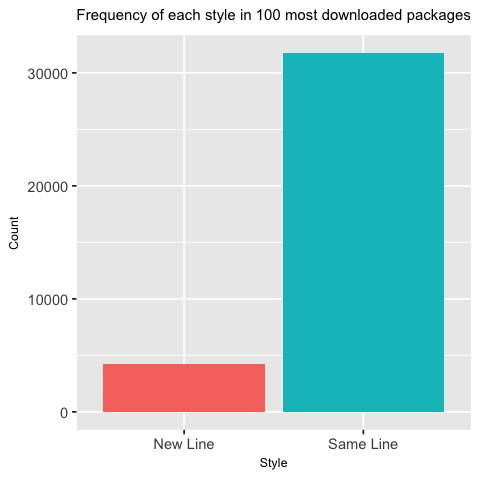

In [20]:
ggplot(styles_by_matches, aes(x = style, y = count, fill = style)) +
    geom_bar(stat = "identity") + guides(fill = FALSE) +
    scale_x_discrete(labels = c("new_line" = "New Line", "same_line" = "Same Line")) +
    labs(title = "Frequency of each style in 100 most downloaded packages", x = "Style", y = "Count") +
    theme(title = element_text(size = 7.5))

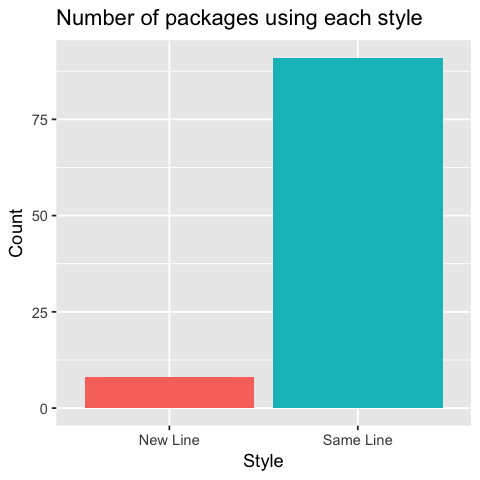

In [21]:
ggplot(styles_by_pkgs, aes(x = style, y = count, fill = style)) +
    geom_bar(stat = "identity") + guides(fill = FALSE) +
    scale_x_discrete(labels = c("new_line" = "New Line", "same_line" = "Same Line")) +
    labs(title = "Number of packages using each style", x = "Style", y = "Count")

## Conclusion

Same-lines win hands down. It's not even close.